#Time series forecasting using LightGBM (LGBM) algorithm

LightGBM is abbreviated as Light Gradient Boosting Machine. This ensemble model is composed of a bunch of decision trees. Using LGBM algorithm, the time series forecasting pipeline is built, and it involved the following stages.

1. Train and test data split
2. Data preprocessing
3. Feature Engineering
4. Building forecasting model
5. Model evaluation
6. Conclusion
7. References

## Reading necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import datetime

import lightgbm as lgb
import datetime

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split

## Reading data to pandas dataframe

The model is built using HPC. The folder from which the data is read is kept as "/data". But it should be changed to the folder where the data is stored.

In [ ]:
data_folder = "/data/"

In [ ]:
df_sales = pd.read_csv(data_folder+"sales_train_evaluation.csv")
print(df_sales.shape)
df_sales.head()

(30490, 1947)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
df_calendar = pd.read_csv(data_folder+"calendar.csv")
print(df_calendar.shape)
df_calendar.head()

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
df_sell_prices = pd.read_csv(data_folder+"sell_prices.csv")
print(df_sell_prices.shape)
df_sell_prices.head()

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## Train and test split

Before any processing applied on the data, the sales data of test is split and kept aside. Since it is time series data, random shuffling would disrupt the ordering in the data. So, the data is split based on the location.

In [ ]:
#Before preprocessing the model, split test data sales
#last 28 days of sales
df_ytest_real = df_sales.loc[:,"d_1914":]
print(df_ytest_real.shape)
df_ytest_real.head()

(30490, 28)


,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,0,0,2,0,3,5,0,0,1,...,2,4,0,0,0,0,3,3,0,1
1,0,1,0,0,0,0,0,0,0,1,...,0,1,2,1,1,0,0,0,0,0
2,0,0,1,1,0,2,1,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,0,0,1,2,4,1,6,4,0,0,...,1,1,0,4,0,1,3,0,2,6
4,1,0,2,3,1,0,3,2,3,1,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
#Remove test data details from training data
df_sales.drop(df_sales.loc[:,"d_1914":].columns, axis=1, inplace=True)
print(df_sales.shape)
df_sales.head()

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## Data preprocessing

Data preprocessing is important to alter the data as per the training model needs, and it also cleans the data. The following steps are done in data preprocessing.

1. Datatype conversion
2. Handling missing or null values
3. Dropping unnecessary/repeating attributes
4. Converting categorical attributes to numerical attributes
5. Dataframe alterations as per the model requirements.

In [ ]:
#filling value to use during rolling
vfill = 1000
#vfill = -1

In [ ]:
"""
preprocess calendar dataframe
1. make datatype of columns appropriate
2. convert categorical columns to numerical values (ordinal)
"""
def prepare_caldf(df_cal):
    #convert cols having integer values to type int16
    int_cols = ["wm_yr_wk","wday","month","year","snap_CA","snap_TX","snap_WI"]
    df_cal[int_cols] = df_cal[int_cols].astype("int16")

    #convert date column as type datetime
    df_cal["date"] = pd.to_datetime(df_cal["date"])

    #month, year column already exists, create day column
    df_cal["mday"] = df_cal["date"].dt.day.astype("int8")

    #preprocess event_cols
    #not all events are considered since single event is sufficient to denote day's importance
    event_cols = ["event_name_1"]
    df_cal[event_cols] = df_cal[event_cols].fillna("NA") #convert NaN to NA (Not Applicable)

    #convert categorical attributes to numerical attributes
    for col in event_cols:
        encoder = OrdinalEncoder(cols=col)
        df_cal = encoder.fit_transform(df_cal)
        df_cal[col] = df_cal[col].astype("int16")
        
    #shifting for 28 days
    shift_cols = []
    shift_cols.extend(int_cols)
    shift_cols.extend(event_cols)
    shift_cols.append("mday")
    for col in shift_cols:
        df_cal["shift28_"+col] = df_cal[col].shift(-28).fillna(vfill).astype("int16")
        
    #drop extra and unnecessary columns
    #dropping unshifted columns
    df_cal.drop(shift_cols, axis=1, inplace=True)

    #drop weekday cols because wday is already present
    df_cal.drop("weekday", axis=1, inplace=True)
    
    #dropping unused event cols
    df_cal.drop(["event_type_1","event_type_2","event_name_2"], axis=1, inplace=True)

    return df_cal

In [ ]:
df_cal = prepare_caldf(df_calendar)
df_cal.head()

,date,d,shift28_wm_yr_wk,shift28_wday,shift28_month,shift28_year,shift28_snap_CA,shift28_snap_TX,shift28_snap_WI,shift28_event_name_1,shift28_mday
0,2011-01-29,d_1,11105,1,2,2011,0,0,0,1,26
1,2011-01-30,d_2,11105,2,2,2011,0,0,0,1,27
2,2011-01-31,d_3,11105,3,2,2011,0,0,0,1,28
3,2011-02-01,d_4,11105,4,3,2011,1,1,0,1,1
4,2011-02-02,d_5,11105,5,3,2011,1,0,1,1,2


In [ ]:
"""
preprocess sell_prices dataframe
1. make datatype of columns appropriate
2. convert categorical columns to numerical values (ordinal)
"""
def prepare_pricesdf(df_prices):
    #convert cols having integer values to type int16
    int_cols = ["wm_yr_wk"]
    df_prices[int_cols] = df_prices[int_cols].astype("int16")

    #convert cols having float values to type float16
    float_cols = ["sell_price"]
    df_prices[float_cols] = df_prices[float_cols].astype("float16")
    
    #Rolling operation - upward shift for 28 days
    roll_cols = {"wm_yr_wk":"int16",
                 "sell_price":"float16"}
    for col in roll_cols.items():
        df_prices["shift28_"+col[0]] = df_prices[col[0]].shift(-28).fillna(vfill).astype(col[1])
    
    #drop unshifted columns
    df_prices.drop(roll_cols.keys(), axis=1, inplace=True)    

    return df_prices

In [ ]:
df_prices = prepare_pricesdf(df_sell_prices)
df_prices.head()

,store_id,item_id,shift28_wm_yr_wk,shift28_sell_price
0,CA_1,HOBBIES_1_001,11353,8.257812
1,CA_1,HOBBIES_1_001,11401,8.257812
2,CA_1,HOBBIES_1_001,11402,8.257812
3,CA_1,HOBBIES_1_001,11403,8.257812
4,CA_1,HOBBIES_1_001,11404,8.257812


In [ ]:
#checking for NaN values
df_prices.isna().sum()

store_id              0
item_id               0
shift28_wm_yr_wk      0
shift28_sell_price    0
dtype: int64

In [ ]:
"""
preprocess sales dataframe
1. make datatype of columns appropriate
2. convert categorical columns to numerical values (ordinal)
"""
def prepare_salesdf(df_sales):
    #convert cols having integer values to type int16
    d_cols = df_sales.loc[:,"d_1":].columns
    df_sales[d_cols] = df_sales[d_cols].astype("int16")

    #convert data to different shape to join with other columns
    id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    df_sales = df_sales.melt(id_vars=id_vars, var_name="d", value_name="sales")

    return df_sales

In [ ]:
print(df_sales.shape)
df_sales[["item_id","d","sales"]].head(10)

(58327370, 8)


,item_id,d,sales
0,HOBBIES_1_001,d_1,0
1,HOBBIES_1_002,d_1,0
2,HOBBIES_1_003,d_1,0
3,HOBBIES_1_004,d_1,0
4,HOBBIES_1_005,d_1,0
5,HOBBIES_1_006,d_1,0
6,HOBBIES_1_007,d_1,0
7,HOBBIES_1_008,d_1,12
8,HOBBIES_1_009,d_1,2
9,HOBBIES_1_010,d_1,0


In [ ]:
df_sales = prepare_salesdf(df_sales)
print(df_sales.shape)
df_sales.head()

(58327370, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [ ]:
#Merging the sales and calendar columns
df_merged_salescal = pd.merge(df_sales, df_cal, left_on="d", right_on="d", how="left")
print(f"Dataframe size after sales and calendar dataframes merged: {df_merged_salescal.shape}")
df_merged_salescal.head()

Dataframe size after sales and calendar dataframes merged: (58327370, 18)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,shift28_wm_yr_wk,shift28_wday,shift28_month,shift28_year,shift28_snap_CA,shift28_snap_TX,shift28_snap_WI,shift28_event_name_1,shift28_mday
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26


In [ ]:
#Final merge all the columns together
df_final = pd.merge(df_merged_salescal, df_prices, 
                    left_on=["store_id", "item_id","shift28_wm_yr_wk"], 
                    right_on=["store_id", "item_id","shift28_wm_yr_wk"], 
                    how="left")
print(f"Dataframe size after sales,calendar and prices dataframes merged: {df_final.shape}")
df_final.head()
#59181090 = 3049 X 10 X 1941 (3049-unique items, 10-different stores, 1941-days)

Dataframe size after sales,calendar and prices dataframes merged: (60501866, 19)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,shift28_wm_yr_wk,shift28_wday,shift28_month,shift28_year,shift28_snap_CA,shift28_snap_TX,shift28_snap_WI,shift28_event_name_1,shift28_mday,shift28_sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,NaN


In [ ]:
print("count of unique items:",len(df_final["item_id"].unique()))
print("count of departments:", len(df_final["dept_id"].unique()))
print("count of diff categories:",len(df_final["cat_id"].unique()))
print("count of diff ids:",len(df_final["id"].unique()))

count of unique items: 3049
count of departments: 7
count of diff categories: 3
count of diff ids: 30490


In [ ]:
#checking for NaN values
df_final.isna().sum()
#only sell_price col has na values

id                             0
item_id                        0
dept_id                        0
cat_id                         0
store_id                       0
state_id                       0
d                              0
sales                          0
date                           0
shift28_wm_yr_wk               0
shift28_wday                   0
shift28_month                  0
shift28_year                   0
shift28_snap_CA                0
shift28_snap_TX                0
shift28_snap_WI                0
shift28_event_name_1           0
shift28_mday                   0
shift28_sell_price      13958734
dtype: int64

In [ ]:
#checking for Null values
df_final.isnull().sum()

id                             0
item_id                        0
dept_id                        0
cat_id                         0
store_id                       0
state_id                       0
d                              0
sales                          0
date                           0
shift28_wm_yr_wk               0
shift28_wday                   0
shift28_month                  0
shift28_year                   0
shift28_snap_CA                0
shift28_snap_TX                0
shift28_snap_WI                0
shift28_event_name_1           0
shift28_mday                   0
shift28_sell_price      13958734
dtype: int64

In [ ]:
#list of columns
df_final.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'shift28_wm_yr_wk', 'shift28_wday', 'shift28_month',
       'shift28_year', 'shift28_snap_CA', 'shift28_snap_TX', 'shift28_snap_WI',
       'shift28_event_name_1', 'shift28_mday', 'shift28_sell_price'],
      dtype='object')

In [ ]:
#df_final[pd.datetime(2012,12,25)]
#df_final["date"].max() #Ans: Timestamp('2016-05-22 00:00:00')
# print(df_final["date"].max())
# df_final["date"].max() - datetime.timedelta(days=28)

2016-04-24 00:00:00


Timestamp('2016-03-27 00:00:00')

In [ ]:
"""
Preprocess merged dataframe
1. Drop NaN values
2. convert categorical attribute to numerical attributes
3. Drop unnecessary columns
"""
def preprocess_merged(df_tomunge):
    #drop NaN values
    df_tomunge.dropna(inplace=True)
    
    #Drop unnecessary columns - days
    df_tomunge.drop("d", axis=1, inplace=True)
    
    #convert categorical attribute to numerical attributes
    id_cols = [col for col in df_tomunge.columns if "id" in col]
    for col in id_cols:
        encoder = OrdinalEncoder(cols=col)
        df_tomunge = encoder.fit_transform(df_tomunge)
        df_tomunge[col] = df_tomunge[col].astype("int16") 
    
    return df_tomunge

In [ ]:
df_final = preprocess_merged(df_final)
print("shape of df_final:",df_final.shape)
df_final.head()

shape of df_final: (46543906, 18)


,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,shift28_wm_yr_wk,shift28_wday,shift28_month,shift28_year,shift28_snap_CA,shift28_snap_TX,shift28_snap_WI,shift28_event_name_1,shift28_mday,shift28_sell_price
6,1,1,1,1,1,1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,0.419922
7,2,2,1,1,1,1,12,2011-01-29,11105,1,2,2011,0,0,0,1,26,1.559570
8,3,3,1,1,1,1,2,2011-01-29,11105,1,2,2011,0,0,0,1,26,3.169922
10,4,4,1,1,1,1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,5.980469
13,5,5,1,1,1,1,0,2011-01-29,11105,1,2,2011,0,0,0,1,26,0.720215


## Feature Engineering

Feature engineering involves creating new features based on the existing features. The time series features such as lag and rolling statistics features are engineered.

1. **Lag features:** The past values are known as lags. For a time t, lags are t-1, t-2 and so on. This is a new column created by shifting values of an existing column to a particular range n, where n can be any integer within row size, assuming past values as future sales.

2. **Rolling statistics features:** These features are created by performing some statistical calculations (mean, median, sum, maximum, minimum, etc.,) on the existing columns. For example, a rolling mean feature is created by taking the mean of the values of the sliding window of size n, where n can be any integer within row size.

In [ ]:
"""
Feature Engineering
1. Lag features
2. Rolling window features
"""
def feature_engg(df_toengg):   
    #Lag predicts future values based on the past data
    #Lag (downward shift) features from sales
    lags = [7,14,28] #because weekly data seems correlated
    for lag in lags:
        df_toengg["lag{}".format(lag)] = df_toengg.groupby("id")["sales"].transform(lambda grp: grp.shift(lag)).fillna(vfill).astype("int16")
        df_toengg["lag{}_diff".format(lag)] = df_toengg.groupby("id")["sales"].transform(lambda grp: grp.shift(lag)-grp.shift(0)).fillna(vfill).astype("int16")
    
    #Lag features based on sell_prices
    price_lags = [1,7]
    for lag in price_lags:
        df_toengg["pricelag{}".format(lag)] = df_toengg.groupby("id")["shift28_sell_price"].transform(lambda grp: grp.shift(lag)-grp.shift(0)).fillna(vfill).astype("float16")
    
    #Rolling window features
    rws = [7,28]
    for rw in rws:
        for lag in lags:
            df_toengg["rw{}_lag{}".format(rw,lag)] = df_toengg.groupby("id")["sales"].transform(lambda grp: grp.rolling(rw).mean().shift(lag)).fillna(vfill).astype("int16")
            df_toengg["rw{}_lag{}_diff".format(rw,lag)] = df_toengg.groupby("id")["sales"].transform(lambda grp: grp.rolling(rw).mean().shift(lag)-grp.rolling(rw).mean().shift(0)).fillna(vfill).astype("int16")
    
    #finding sales range
    sales_range=[]
    for salecnt in df_toengg["sales"]:
        if salecnt==0:
            sales_range.append(0)
        elif salecnt==1:
            sales_range.append(1)
        elif salecnt==2:
            sales_range.append(2)
        elif(salecnt>2 and salecnt<=5):
            sales_range.append(3)
        elif(salecnt>5 and salecnt<=20):
            sales_range.append(4)
        else:
            sales_range.append(5)
    df_toengg["sales_range"] = sales_range
    df_toengg["sales_range"] = df_toengg["sales_range"].astype("int16")
    
    #Future shift - consider future data for past data
    df_toengg["target"] = df_toengg.groupby("id")["sales"].transform(lambda grp: grp.shift(-28)).fillna(0).astype("int16")
    
    return df_toengg

In [ ]:
df_final = feature_engg(df_final)
print("shape of df_final:",df_final.shape)
df_final.head()

shape of df_final: (46543906, 40)


,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,shift28_wm_yr_wk,shift28_wday,...,rw7_lag28,rw7_lag28_diff,rw28_lag7,rw28_lag7_diff,rw28_lag14,rw28_lag14_diff,rw28_lag28,rw28_lag28_diff,sales_range,target
6,1,1,1,1,1,1,0,2011-01-29,11105,1,...,1000,1000,1000,1000,1000,1000,1000,1000,0,0
7,2,2,1,1,1,1,12,2011-01-29,11105,1,...,1000,1000,1000,1000,1000,1000,1000,1000,4,0
8,3,3,1,1,1,1,2,2011-01-29,11105,1,...,1000,1000,1000,1000,1000,1000,1000,1000,2,8
10,4,4,1,1,1,1,0,2011-01-29,11105,1,...,1000,1000,1000,1000,1000,1000,1000,1000,0,0
13,5,5,1,1,1,1,0,2011-01-29,11105,1,...,1000,1000,1000,1000,1000,1000,1000,1000,0,0


In [ ]:
df_final.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sales',
       'date', 'shift28_wm_yr_wk', 'shift28_wday', 'shift28_month',
       'shift28_year', 'shift28_snap_CA', 'shift28_snap_TX', 'shift28_snap_WI',
       'shift28_event_name_1', 'shift28_mday', 'shift28_sell_price', 'lag7',
       'lag7_diff', 'lag14', 'lag14_diff', 'lag28', 'lag28_diff', 'pricelag1',
       'pricelag7', 'rw7_lag7', 'rw7_lag7_diff', 'rw7_lag14', 'rw7_lag14_diff',
       'rw7_lag28', 'rw7_lag28_diff', 'rw28_lag7', 'rw28_lag7_diff',
       'rw28_lag14', 'rw28_lag14_diff', 'rw28_lag28', 'rw28_lag28_diff',
       'sales_range', 'target'],
      dtype='object')

In [ ]:
#dropping unnecessary attributes
df_final_orig = df_final.copy()
df_final.drop(["shift28_wm_yr_wk",'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'sales'], axis=1, inplace=True)
print(df_final.shape)
df_final.head()

(46543906, 32)


,date,shift28_wday,shift28_month,shift28_year,shift28_snap_CA,shift28_snap_TX,shift28_snap_WI,shift28_event_name_1,shift28_mday,shift28_sell_price,...,rw7_lag28,rw7_lag28_diff,rw28_lag7,rw28_lag7_diff,rw28_lag14,rw28_lag14_diff,rw28_lag28,rw28_lag28_diff,sales_range,target
6,2011-01-29,1,2,2011,0,0,0,1,26,0.419922,...,1000,1000,1000,1000,1000,1000,1000,1000,0,0
7,2011-01-29,1,2,2011,0,0,0,1,26,1.559570,...,1000,1000,1000,1000,1000,1000,1000,1000,4,0
8,2011-01-29,1,2,2011,0,0,0,1,26,3.169922,...,1000,1000,1000,1000,1000,1000,1000,1000,2,8
10,2011-01-29,1,2,2011,0,0,0,1,26,5.980469,...,1000,1000,1000,1000,1000,1000,1000,1000,0,0
13,2011-01-29,1,2,2011,0,0,0,1,26,0.720215,...,1000,1000,1000,1000,1000,1000,1000,1000,0,0


In [ ]:
"""
** splitting training data into train,validation and test data based on location **
Time series data should not be split randomly, because that would disrupt the ordering in the data.
Instead, it needs to be split based on the location.

Also, the given data consisted only of sales of 1941 days.
Based on that, new features are engineered. And, that is split into train, validation and test data.

Models like ARIMA, FBProphet provides predict() function where the values would be predicted for the given number of days
But, LGBM is a traditional regression model, which expects some test data to work on to predict the future sales.
So, based on the training data, validation and test data are created and used to predict future sales.
"""
def split_data(df_tosplit, random_state=10):
    #Ignoring last 56 days (for validation and test data) and first 56 days (because lag and rolling window features are created based on that)
    xtrain = df_tosplit[ (df_tosplit["date"] < df_tosplit["date"].max() - datetime.timedelta(days=56)) & (df_tosplit["date"] > df_tosplit["date"].min() + datetime.timedelta(days=56))
                  ].set_index("date").drop("target",axis=1)
    
    #considering only final targets
    ytrain = df_tosplit[ (df_tosplit["date"] < df_tosplit["date"].max() - datetime.timedelta(days=56)) & (df_tosplit["date"] > df_tosplit["date"].min() + datetime.timedelta(days=56))
                  ].set_index("date")["target"]
    
    #validation data (ignoring last 28 days for test data, considering first 28 days in the last 56 days)
    xval = df_tosplit[ (df_tosplit["date"] < df_tosplit["date"].max() - datetime.timedelta(days=28)) & (df_tosplit["date"] >= df_tosplit["date"].max() - datetime.timedelta(days=56))
                  ].set_index("date").drop("target",axis=1)
    
    #considering only final targets
    yval = df_tosplit[ (df_tosplit["date"] < df_tosplit["date"].max() - datetime.timedelta(days=28)) & (df_tosplit["date"] >= df_tosplit["date"].max() - datetime.timedelta(days=56))
                  ].set_index("date")["target"]
    
    #creating test data considering only last 28 days
    xtest = df_tosplit[ (df_tosplit["date"] > df_tosplit["date"].max() - datetime.timedelta(days=28))].set_index("date").drop("target",axis=1)
    

    return xtrain, xval, ytrain, yval, xtest

In [ ]:
#with train, val and test split based on location
xtrain, xval, ytrain, yval, xtest = split_data(df_final)

print("xtrain shape: {}".format(xtrain.shape))
print("ytrain shape: {}".format(ytrain.shape))
print("xval shape: {}".format(xval.shape))
print("yval shape: {}".format(yval.shape))
print("xtest shape: {}".format(xtest.shape))

xtrain shape: (44016375, 30)
ytrain shape: (44016375,)
xval shape: (853720, 30)
yval shape: (853720,)
xtest shape: (853720, 30)


## Building forecasting model using LightGBM

In [ ]:
"""
Building forecasting model
model training with different parameter values
"""
def train_lgbm(xtrain, xval, ytrain, yval):
    #create dataset as per lgb model expects
    train_data = lgb.Dataset(xtrain, label=ytrain)
    val_data = lgb.Dataset(xval, label=yval)
    
    #lgbm parameters
    #force_row_wise or force_col_wise is decided by the system if it is set to false
    #that adds additional overhead on training time, so setting force_row_wise as True
    #because, system ultimately chooses force_row_wise, which can be seen in printed training verbose.
    params = { "seed":200, #random_state
               #"learning_rate": 0.001, #learns very slowly, model takes forever to run
               "learning_rate": 1,
               "num_leaves": 64,
               "force_row_wise": True, #even by default, it get sets as true
               #"sub_row": 0.7,
               #"bagging_freq": 1,
               "colsample_bytree": 0.70, #to help with overfitting, sampling along features
              "metric":"rmse",
               "objective": "regression"}#uses L2 regularization
    
    evals_result = {}
    #model training
    lgbmodel = lgb.train(params, train_data, num_boost_round=1000, valid_sets = [val_data], evals_result=evals_result, early_stopping_rounds=25, verbose_eval=5)
    
    #prediction on training and validation data
    trainpred = lgbmodel.predict(xtrain)
    valpred = lgbmodel.predict(xval)
    
    return lgbmodel, evals_result, trainpred, valpred

In [ ]:
%%time
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgbmodel, evals_result, trainpred, valpred = train_lgbm(xtrain, xval, ytrain, yval)

[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 38165497, number of used features: 31
[LightGBM] [Info] Start training from score 1.386413
Training until validation scores don't improve for 25 rounds
[5]	valid_0's rmse: 3.58976
[10]	valid_0's rmse: 3.19763
[15]	valid_0's rmse: 2.9761
[20]	valid_0's rmse: 2.85355
[25]	valid_0's rmse: 2.7848
[30]	valid_0's rmse: 2.74564
[35]	valid_0's rmse: 2.72125
[40]	valid_0's rmse: 2.70488
[45]	valid_0's rmse: 2.69154
[50]	valid_0's rmse: 2.68313
[55]	valid_0's rmse: 2.67623
[60]	valid_0's rmse: 2.67012
[65]	valid_0's rmse: 2.66513
[70]	valid_0's rmse: 2.65932
[75]	valid_0's rmse: 2.65512
[80]	valid_0's rmse: 2.652
[85]	valid_0's rmse: 2.64966
[90]	valid_0's rmse: 2.64698
[95]	valid_0's rmse: 2.64374
[100]	valid_0's rmse: 2.64205
[105]	valid_0's rmse: 2.63982
[110]	valid_0's rmse: 2.63718
[115]	valid_0's rmse: 2.63576
[120]	valid_0's rmse: 2.63405
[125]	valid_0's rmse: 2.63153
[130]	valid_0's rmse: 2.63007


In [ ]:
%%time
#removed force_row_wise=true
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgbmodel, evals_result, trainpred, valpred = train_lgbm(xtrain, xval, ytrain, yval)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.587957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 38891159, number of used features: 31
[LightGBM] [Info] Start training from score 1.387357
Training until validation scores don't improve for 25 rounds
[5]	valid_0's rmse: 3.56251
[10]	valid_0's rmse: 3.17285
[15]	valid_0's rmse: 2.9574
[20]	valid_0's rmse: 2.83824
[25]	valid_0's rmse: 2.77289
[30]	valid_0's rmse: 2.73649
[35]	valid_0's rmse: 2.71446
[40]	valid_0's rmse: 2.70069
[45]	valid_0's rmse: 2.68986
[50]	valid_0's rmse: 2.67994
[55]	valid_0's rmse: 2.67308
[60]	valid_0's rmse: 2.66618
[65]	valid_0's rmse: 2.66019
[70]	valid_0's rmse: 2.65455
[75]	valid_0's rmse: 2.65106
[80]	valid_0's rmse: 2.64727
[85]	valid_0's rmse: 2.64421
[90]	valid_0's rmse: 2.64179
[95]	va

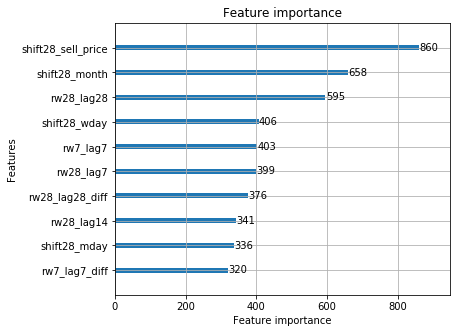

In [ ]:
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgb.plot_importance(lgbmodel, importance_type="split", precision=0, max_num_features=10, figsize=(6,5) )

In [ ]:
%%time
#removed sales feature, train and test split based on location
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgbmodel, evals_result, trainpred, valpred = train_lgbm(xtrain, xval, ytrain, yval)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 4.167903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 44016375, number of used features: 30
[LightGBM] [Info] Start training from score 1.386278
Training until validation scores don't improve for 25 rounds
[5]	valid_0's rmse: 3.02466
[10]	valid_0's rmse: 2.66943
[15]	valid_0's rmse: 2.46866
[20]	valid_0's rmse: 2.35649
[25]	valid_0's rmse: 2.29459
[30]	valid_0's rmse: 2.25762
[35]	valid_0's rmse: 2.23775
[40]	valid_0's rmse: 2.22438
[45]	valid_0's rmse: 2.21546
[50]	valid_0's rmse: 2.20986
[55]	valid_0's rmse: 2.20602
[60]	valid_0's rmse: 2.20183
[65]	valid_0's rmse: 2.19898
[70]	valid_0's rmse: 2.19695
[75]	valid_0's rmse: 2.19523
[80]	valid_0's rmse: 2.19357
[85]	valid_0's rmse: 2.19239
[90]	valid_0's rmse: 2.19083
[95]	v

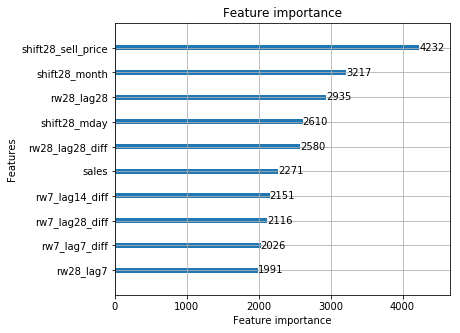

In [ ]:
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgb.plot_importance(lgbmodel, importance_type="split", precision=0, max_num_features=10, figsize=(6,5) )

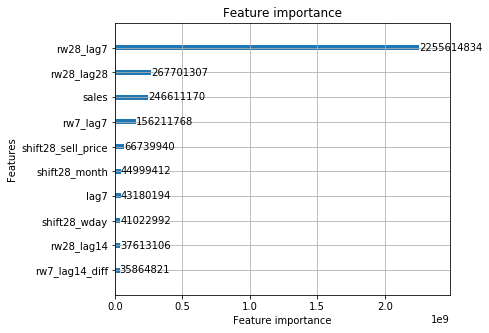

In [ ]:
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgb.plot_importance(lgbmodel, importance_type="gain", precision=0, max_num_features=10, figsize=(6,5) )

In [ ]:
%%time
#train, validation and test split based on location
#{ learning_rate: 0.001, colsample_bytree: 0.70, num_boost_rounds: 1000 }
lgbmodel, evals_result, trainpred, valpred = train_lgbm(xtrain, xval, ytrain, yval)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.784412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 44016375, number of used features: 30
[LightGBM] [Info] Start training from score 1.386278
Training until validation scores don't improve for 25 rounds
[5]	valid_0's rmse: 3.6219
[10]	valid_0's rmse: 3.6113
[15]	valid_0's rmse: 3.60077
[20]	valid_0's rmse: 3.5903
[25]	valid_0's rmse: 3.57989
[30]	valid_0's rmse: 3.56954
[35]	valid_0's rmse: 3.55931
[40]	valid_0's rmse: 3.54905
[45]	valid_0's rmse: 3.53894
[50]	valid_0's rmse: 3.52884
[55]	valid_0's rmse: 3.51889
[60]	valid_0's rmse: 3.50893
[65]	valid_0's rmse: 3.49909
[70]	valid_0's rmse: 3.48929
[75]	valid_0's rmse: 3.47962
[80]	valid_0's rmse: 3.46999
[85]	valid_0's rmse: 3.4604
[90]	valid_0's rmse: 3.45087
[95]	valid

KeyboardInterrupt: 

In [ ]:
%%time
#train, validation and test split based on location
#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
#Getting stucked at the local minima
lgbmodel, evals_result, trainpred, valpred = train_lgbm(xtrain, xval, ytrain, yval)

[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 44016375, number of used features: 30
[LightGBM] [Info] Start training from score 1.386278
Training until validation scores don't improve for 25 rounds
[5]	valid_0's rmse: 2.83628
[10]	valid_0's rmse: 2.4834
[15]	valid_0's rmse: 2.33177
[20]	valid_0's rmse: 2.26259
[25]	valid_0's rmse: 2.23465
[30]	valid_0's rmse: 2.22009
[35]	valid_0's rmse: 2.21158
[40]	valid_0's rmse: 2.20546
[45]	valid_0's rmse: 2.20113
[50]	valid_0's rmse: 2.199
[55]	valid_0's rmse: 2.19707
[60]	valid_0's rmse: 2.19504
[65]	valid_0's rmse: 2.19359
[70]	valid_0's rmse: 2.1915
[75]	valid_0's rmse: 2.18968
[80]	valid_0's rmse: 2.18871
[85]	valid_0's rmse: 2.18808
[90]	valid_0's rmse: 2.18689
[95]	valid_0's rmse: 2.18634
[100]	valid_0's rmse: 2.18557
[105]	valid_0's rmse: 2.18499
[110]	valid_0's rmse: 2.18289
[115]	valid_0's rmse: 2.1826
[120]	valid_0's rmse: 2.18155
[125]	valid_0's rmse: 2.18133
[130]	valid_0's rmse: 2.18081
[

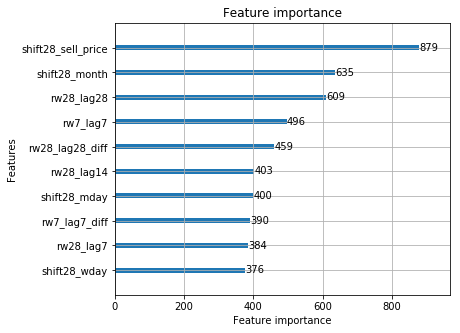

In [ ]:
#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
lgb.plot_importance(lgbmodel, importance_type="split", precision=0, max_num_features=10, figsize=(6,5) )

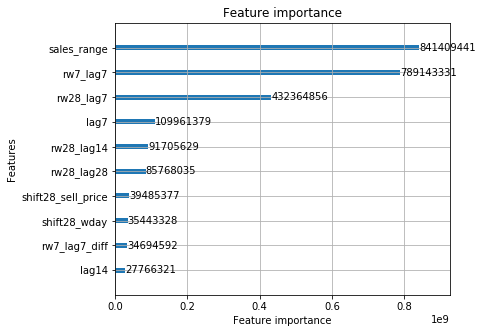

In [ ]:
#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
lgb.plot_importance(lgbmodel, importance_type="gain", precision=0, max_num_features=10, figsize=(6,5) )

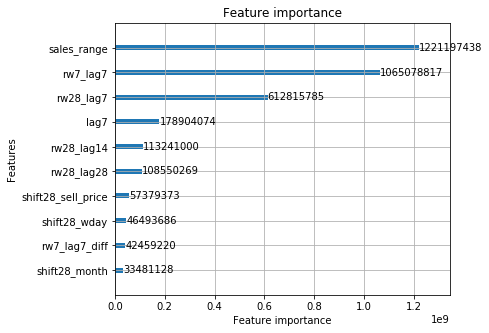

In [ ]:
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
lgb.plot_importance(lgbmodel, importance_type="gain", precision=0, max_num_features=10, figsize=(6,5) )

In [ ]:
%%time
#train, validation and test split based on location
#{ learning_rate: 1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
#Getting stucked at the local minima
lgbmodel, evals_result, trainpred, valpred = train_lgbm(xtrain, xval, ytrain, yval)

[LightGBM] [Info] Total Bins 2411
[LightGBM] [Info] Number of data points in the train set: 44016375, number of used features: 30
[LightGBM] [Info] Start training from score 1.386278
Training until validation scores don't improve for 25 rounds
[5]	valid_0's rmse: 2.26675
[10]	valid_0's rmse: 2.25297
[15]	valid_0's rmse: 2.24524
[20]	valid_0's rmse: 2.24467
[25]	valid_0's rmse: 2.24305
[30]	valid_0's rmse: 2.24188
[35]	valid_0's rmse: 2.24122
[40]	valid_0's rmse: 2.23459
[45]	valid_0's rmse: 2.23532
[50]	valid_0's rmse: 2.24099
[55]	valid_0's rmse: 2.24111
[60]	valid_0's rmse: 2.24607
[65]	valid_0's rmse: 2.24587
Early stopping, best iteration is:
[42]	valid_0's rmse: 2.23408
CPU times: user 23min 42s, sys: 13.7 s, total: 23min 56s
Wall time: 57.8 s


In [ ]:
"""
Saving different models for the future use
Note: Original folders names are removed, since it had SJSU ID
"""
#lgbmodel.save_model('/models/lgbm_models/lgbm_model_2.20.txt')

#saving model after removing sales column, train-test split based on locations
#lgbmodel.save_model('/models/lgbm_models/lgbm_model_tts_loc.txt')

#{ learning_rate: 0.001, colsample_bytree: 0.70, num_boost_rounds: 1000 }
#lgbmodel.save_model('/models/lgbm_models/lgbm_model_tts_0001.txt')

#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
lgbmodel.save_model('/models/lgbm_models/lgbm_model_tts_01.txt')

#lgbmodel = lgb.Booster(model_file='/models/lgbm_models/lgbm_model_2.20.txt')

# Output to JSON
#model_json = gbm.dump_model()

## Model Evaluation

The trained model is evaluated on the validation and test data to analyse the model performance on sales prediction. The evaluation metric used is RMSE and r2, which is explained below.

1. **RMSE(Root Mean Squared Error):** RMSE finds the prediction error by calculating the mean of aggregation of the squared difference between the predicted and the actual values of all items. The higher the model's prediction varies from the actual values, the higher it gets penalized by squaring the error. So, this metric helps to understand the difference of the model's prediction to the actual sales on average.

2. **r2(R squared):** This error metric helps to understand how close the predicted value is to the actual ones. The greater the r2 score,the better the model performance.

In [ ]:
"""
Model performance analysis
Finding below errors
1. Root Mean squared error (RMSE)
2. R2 score
"""
from sklearn.metrics import mean_squared_error, r2_score

def find_error(actual, pred, algo="Lightgbm"):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    print("{} RMS error:{}".format(algo,rmse))

    r2 = r2_score(actual, pred)
    print("{} R2 score:{}".format(algo,r2))
    return rmse, r2

In [ ]:
#Validation error prediction
#split based on location (train, val and test)
#{ learning_rate: 0.07, colsample_bytree: 0.85, num_boost_rounds: 800 }
val_rmse, val_r2 = find_error(yval,valpred)

Lightgbm RMS error:2.1846645373869658
Lightgbm R2 score:0.638310467154809


In [ ]:
#without wm_yr_Wk cols - the dominating column
#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
val_rmse, val_r2 = find_error(yval,valpred)

Lightgbm RMS error:2.5544297921452124
Lightgbm R2 score:0.6425785775147639


In [ ]:
#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
val_rmse, val_r2 = find_error(yval,valpred)

Lightgbm RMS error:2.1802512566240635
Lightgbm R2 score:0.6397703024164042


In [ ]:
xtest.head()

,shift28_wday,shift28_month,shift28_year,shift28_snap_CA,shift28_snap_TX,shift28_snap_WI,shift28_event_name_1,shift28_mday,shift28_sell_price,lag7,...,rw7_lag14_diff,rw7_lag28,rw7_lag28_diff,rw28_lag7,rw28_lag7_diff,rw28_lag14,rw28_lag14_diff,rw28_lag28,rw28_lag28_diff,sales_range
date,,,,,,,,,,,,,,,,,,,,,
2016-03-27,2,4,2016,0,0,0,1,24,8.382812,3,...,0,1,0,1,0,0,0,1,0,1
2016-03-27,2,4,2016,0,0,0,1,24,3.970703,0,...,0,0,0,0,0,0,0,0,0,1
2016-03-27,2,4,2016,0,0,0,1,24,2.970703,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-27,2,4,2016,0,0,0,1,24,4.640625,1,...,-2,2,-1,1,0,1,0,2,0,4
2016-03-27,2,4,2016,0,0,0,1,24,2.880859,2,...,0,0,0,1,0,1,0,1,0,0


### Prediction of test error on the final best model

The models are evaluated on the validation data using RMSE (Root Mean Squared Error). And, the model with the lowest error is selected to find the test error.

In [ ]:
#{ learning_rate: 0.1, colsample_bytree: 0.70, num_boost_rounds: 1000 }
testpred = lgbmodel.predict(xtest)
#val_rmse, val_r2 = find_error(yval,testpred)
testpred

array([0.9409397 , 0.37546866, 0.28696866, ..., 1.086688  , 1.57782963,
       1.25155736])

In [ ]:
#split based on location (train, val and test)
arpred = np.array(testpred, dtype="float16")
arpred = np.reshape(arpred, (30490,28), order='F')
df_testpred = pd.DataFrame(arpred, columns=df_ytest_real.columns)
df_testpred

,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0.986816,1.011719,0.984375,0.948730,1.067383,1.223633,1.400391,1.067383,0.834473,0.745117,...,0.993164,1.406250,1.283203,0.960938,1.093750,1.069336,1.216797,1.023438,1.458008,1.115234
1,0.375732,0.252197,0.252197,0.344971,0.340088,0.375488,0.439209,0.402588,0.289062,0.262207,...,0.295654,0.337402,0.342529,0.279541,0.257568,0.349121,0.289551,0.317627,0.361328,0.361328
2,0.292969,0.275635,0.275635,0.275635,0.399658,0.453125,0.562012,0.360596,0.362793,0.293945,...,0.548340,0.480957,1.260742,0.979492,0.937012,0.964355,0.638184,0.489258,0.531738,0.829102
3,1.695312,1.534180,1.488281,1.219727,1.665039,1.752930,1.861328,1.391602,1.470703,1.255859,...,1.358398,2.179688,2.382812,1.869141,1.618164,1.621094,1.573242,1.804688,2.462891,2.494141
4,1.227539,0.927734,1.166016,1.154297,1.135742,1.383789,1.790039,1.414062,1.353516,1.132812,...,1.202148,1.489258,1.542969,1.089844,1.067383,1.036133,1.120117,1.177734,1.467773,1.681641
5,1.191406,1.223633,1.182617,0.942871,1.221680,1.493164,1.521484,1.238281,1.246094,1.215820,...,1.185547,1.101562,0.986816,0.918945,1.106445,0.958008,0.463379,0.976074,0.832520,0.814941
6,0.410645,0.428955,0.259277,0.308838,0.415039,0.273193,0.332520,0.372559,0.332520,0.226074,...,0.358398,0.356934,0.362061,0.369141,0.281494,0.312988,0.253174,0.246216,0.441895,0.441895
7,5.074219,5.929688,5.417969,5.257812,6.148438,9.820312,11.156250,8.250000,8.726562,8.648438,...,7.296875,8.601562,6.734375,7.128906,5.593750,5.781250,6.871094,5.769531,6.898438,6.417969
8,0.445312,0.532227,0.350342,0.412109,0.560059,0.382812,0.914062,0.738281,0.428467,0.329102,...,0.417236,0.450439,0.793945,0.935547,1.124023,0.790527,0.790527,0.818359,0.956543,0.993164
9,0.367676,0.368652,0.379883,0.368652,0.408203,0.425293,0.940430,0.944824,0.939453,0.807617,...,0.697266,0.630371,0.677734,0.544434,0.449463,0.430176,0.389648,0.669434,0.489014,0.602539


In [ ]:
#Finding the test error
test_rmse, test_r2 = find_error(df_ytest_real, df_testpred)

Lightgbm RMS error:2.210263973155803
Lightgbm R2 score:0.6255117765117822


Text(0.5,1,'Actual Vs predicted sales')

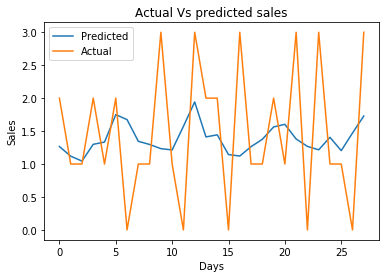

In [ ]:
"""
** Final test plot **
The predicted sales using the final hypothesis is plotted with the actual sales
"""
sample = 28
#for sample in range(df_testpred.shape[1]):
plt.plot(df_testpred.values[sample], label = 'Predicted')
plt.plot(df_ytest_real.values[sample], label = 'Actual')
plt.legend(loc = 'upper left')
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Actual Vs predicted sales")

## Conclusion

For this project, LightGBM is chosen as one of the algorithms to build time series forecasting model. LightGBM is used by 4/5 of winning models of M5 competition. This motivated to understand and analyse LGBM model. Since the competition happened very recently, there has not been any resources released, but the youtube discussion on the final results was helpful to get some insights.

LightGBM open source package is used for this implementation. The model test's RMSE error is 2.2. I tried with varying parameters by differing learning rate, boosting rounds, percentage of sampling, etc. But in all training, after the error reaches 2.18, the model's execution is stopped. I enabled early stopping, if there is not any improvement in the error for 25 iterations. One possibility is, the model might struck in local minima and finds difficulty to reach global minima. I tried with increasing learning rate hoping it would give larger steps that might overlook the local minima, but there is not much help with that.

LightBGM is used in combination with neural networks to improve its performance. This type of hybrid models might help to improve the performance. As a future work, this project can be extended to try with various combinations of advanced networks with LightBGM to analyze its performance. Overall, this project helped to understand the process involved in all the stages of building the time series forecasting model.


## References

1. “The M5 Competition.” YouTube, YouTube, 30 Oct. 2020, www.youtube.com/watch?v=dvNuOSHCLUI&ab_channel=InternationalInstituteofForecasters.
2. Y. Cao and L. Gui, "Multi-Step wind power forecasting model Using LSTM networks, Similar Time Series and LightGBM," 2018 5th International Conference on Systems and Informatics (ICSAI), Nanjing, 2018, pp. 192-197, doi: 10.1109/ICSAI.2018.8599498.
3. "Welcome to LightGBM's Documentation!" - LightGBM 3.1.1.99 Documentation, lightgbm.readthedocs.io/en/latest/
4. “The M5 Competition.” MOFC, 19 Nov. 2020, mofc.unic.ac.cy/m5-competition/.

